In [1]:
import napari
import napari_stress
import napari_process_points_and_surfaces as nppas
import vedo
import tqdm

from skimage import io, filters
import os
import numpy as np

In [2]:
# create viewer
viewer = napari.Viewer(ndisplay=3)

INFO:xmlschema:Resource 'XMLSchema.xsd' is already loaded
Plugin 'napari-spatial-statistics' provided a non-callable type to `napari_experimental_provide_function`: <class 'sip.wrappertype'>. Function widget ignored.


In [3]:
directory = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\20_STRESS\1_first_data'
raw = io.imread(os.path.join(directory, 'ExampleTifSequence-InteriorLabel-vsx_2.076um-vsz_3.998um-TimeInterval_3.00min-21timesteps.tif'))

In [4]:
# Config
vsz = 3.998
vsy = 2.076
vsx = 2.076
n_frames = raw.shape[0]

In [5]:
viewer.add_image(raw, scale=[vsz, vsy, vsx], name='Raw data')

<Image layer 'Raw data' at 0x1470594d190>

## Preprocess

We first resample the image to isotropic voxel size and create a binary mask

In [6]:
# Resample
resampled_image = []
for t in range(n_frames):
    resampled_image.append(napari_stress.resample(raw[t], vsz=vsz, vsy=vsy, vsx=vsx))
resampled_image = np.asarray(resampled_image)
viewer.add_image(resampled_image, scale = 3 * [np.min([vsz, vsy, vsx])])

<Image layer 'resampled_image' at 0x1470594d0a0>

In [7]:
# Masking
binary_image = resampled_image > filters.threshold_otsu(resampled_image)
binary_image_layer = viewer.add_labels(binary_image, scale = 3 * [np.min([vsz, vsy, vsx])])

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


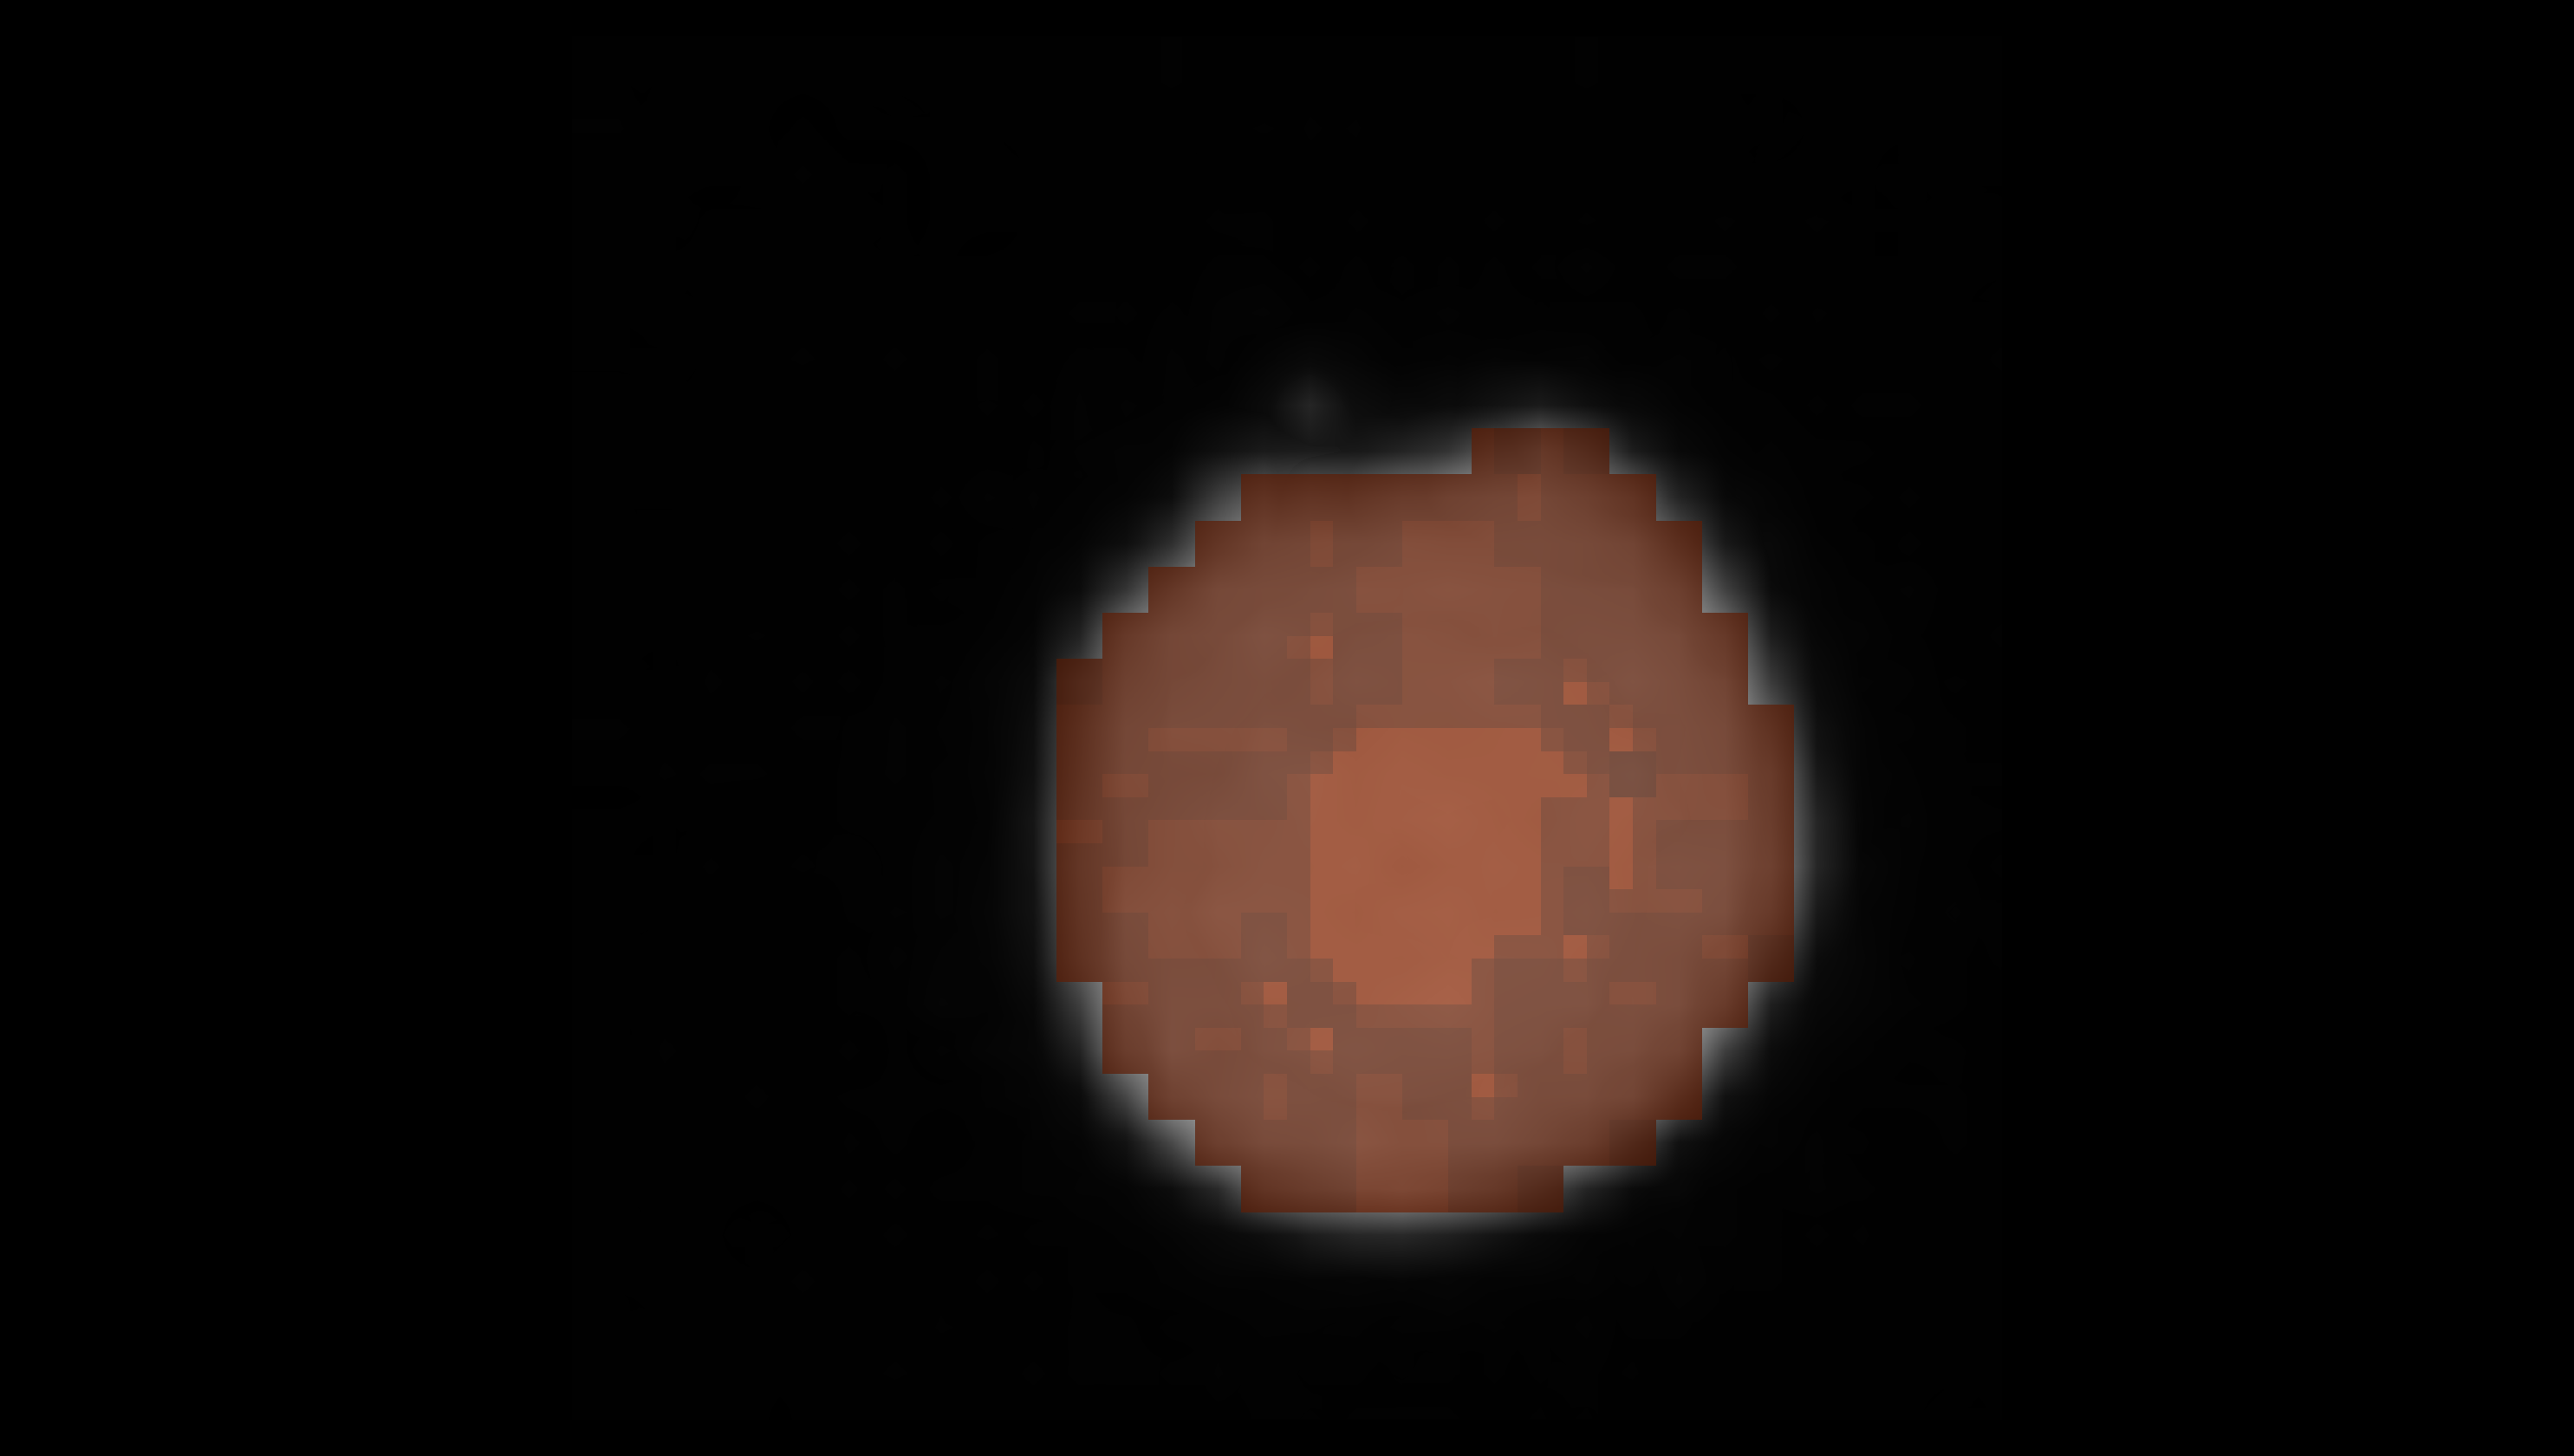

In [8]:
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Create surface

We use the marching cubes algorithm to create a surface from the binary image. We then smooth the surface a bit.

In [9]:
# Create surface
surface = napari_stress.surface_from_label(binary_image, scale = 3 * [np.min([vsz, vsy, vsx])])
surface_layer = viewer.add_surface(napari_stress.list_of_surfaces_to_surface(surface))

Alternative shading modes are only available in 3D, defaulting to none


In [10]:
# Smooth surface
smoothed_surfaces = []
for t in range(n_frames):
    points = surface[t].points()
    faces = surface[t].faces()
    smoothed_surf = nppas.filter_smooth_laplacian((points, faces), number_of_iterations=3)
    smoothed_surfaces.append(vedo.mesh.Mesh((smoothed_surf[0], smoothed_surf[1])))
        
smoothed_surface_layer = viewer.add_surface(napari_stress.list_of_surfaces_to_surface(smoothed_surfaces), name='Smoothed surface')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Alternative shading modes are only available in 3D, defaulting to none


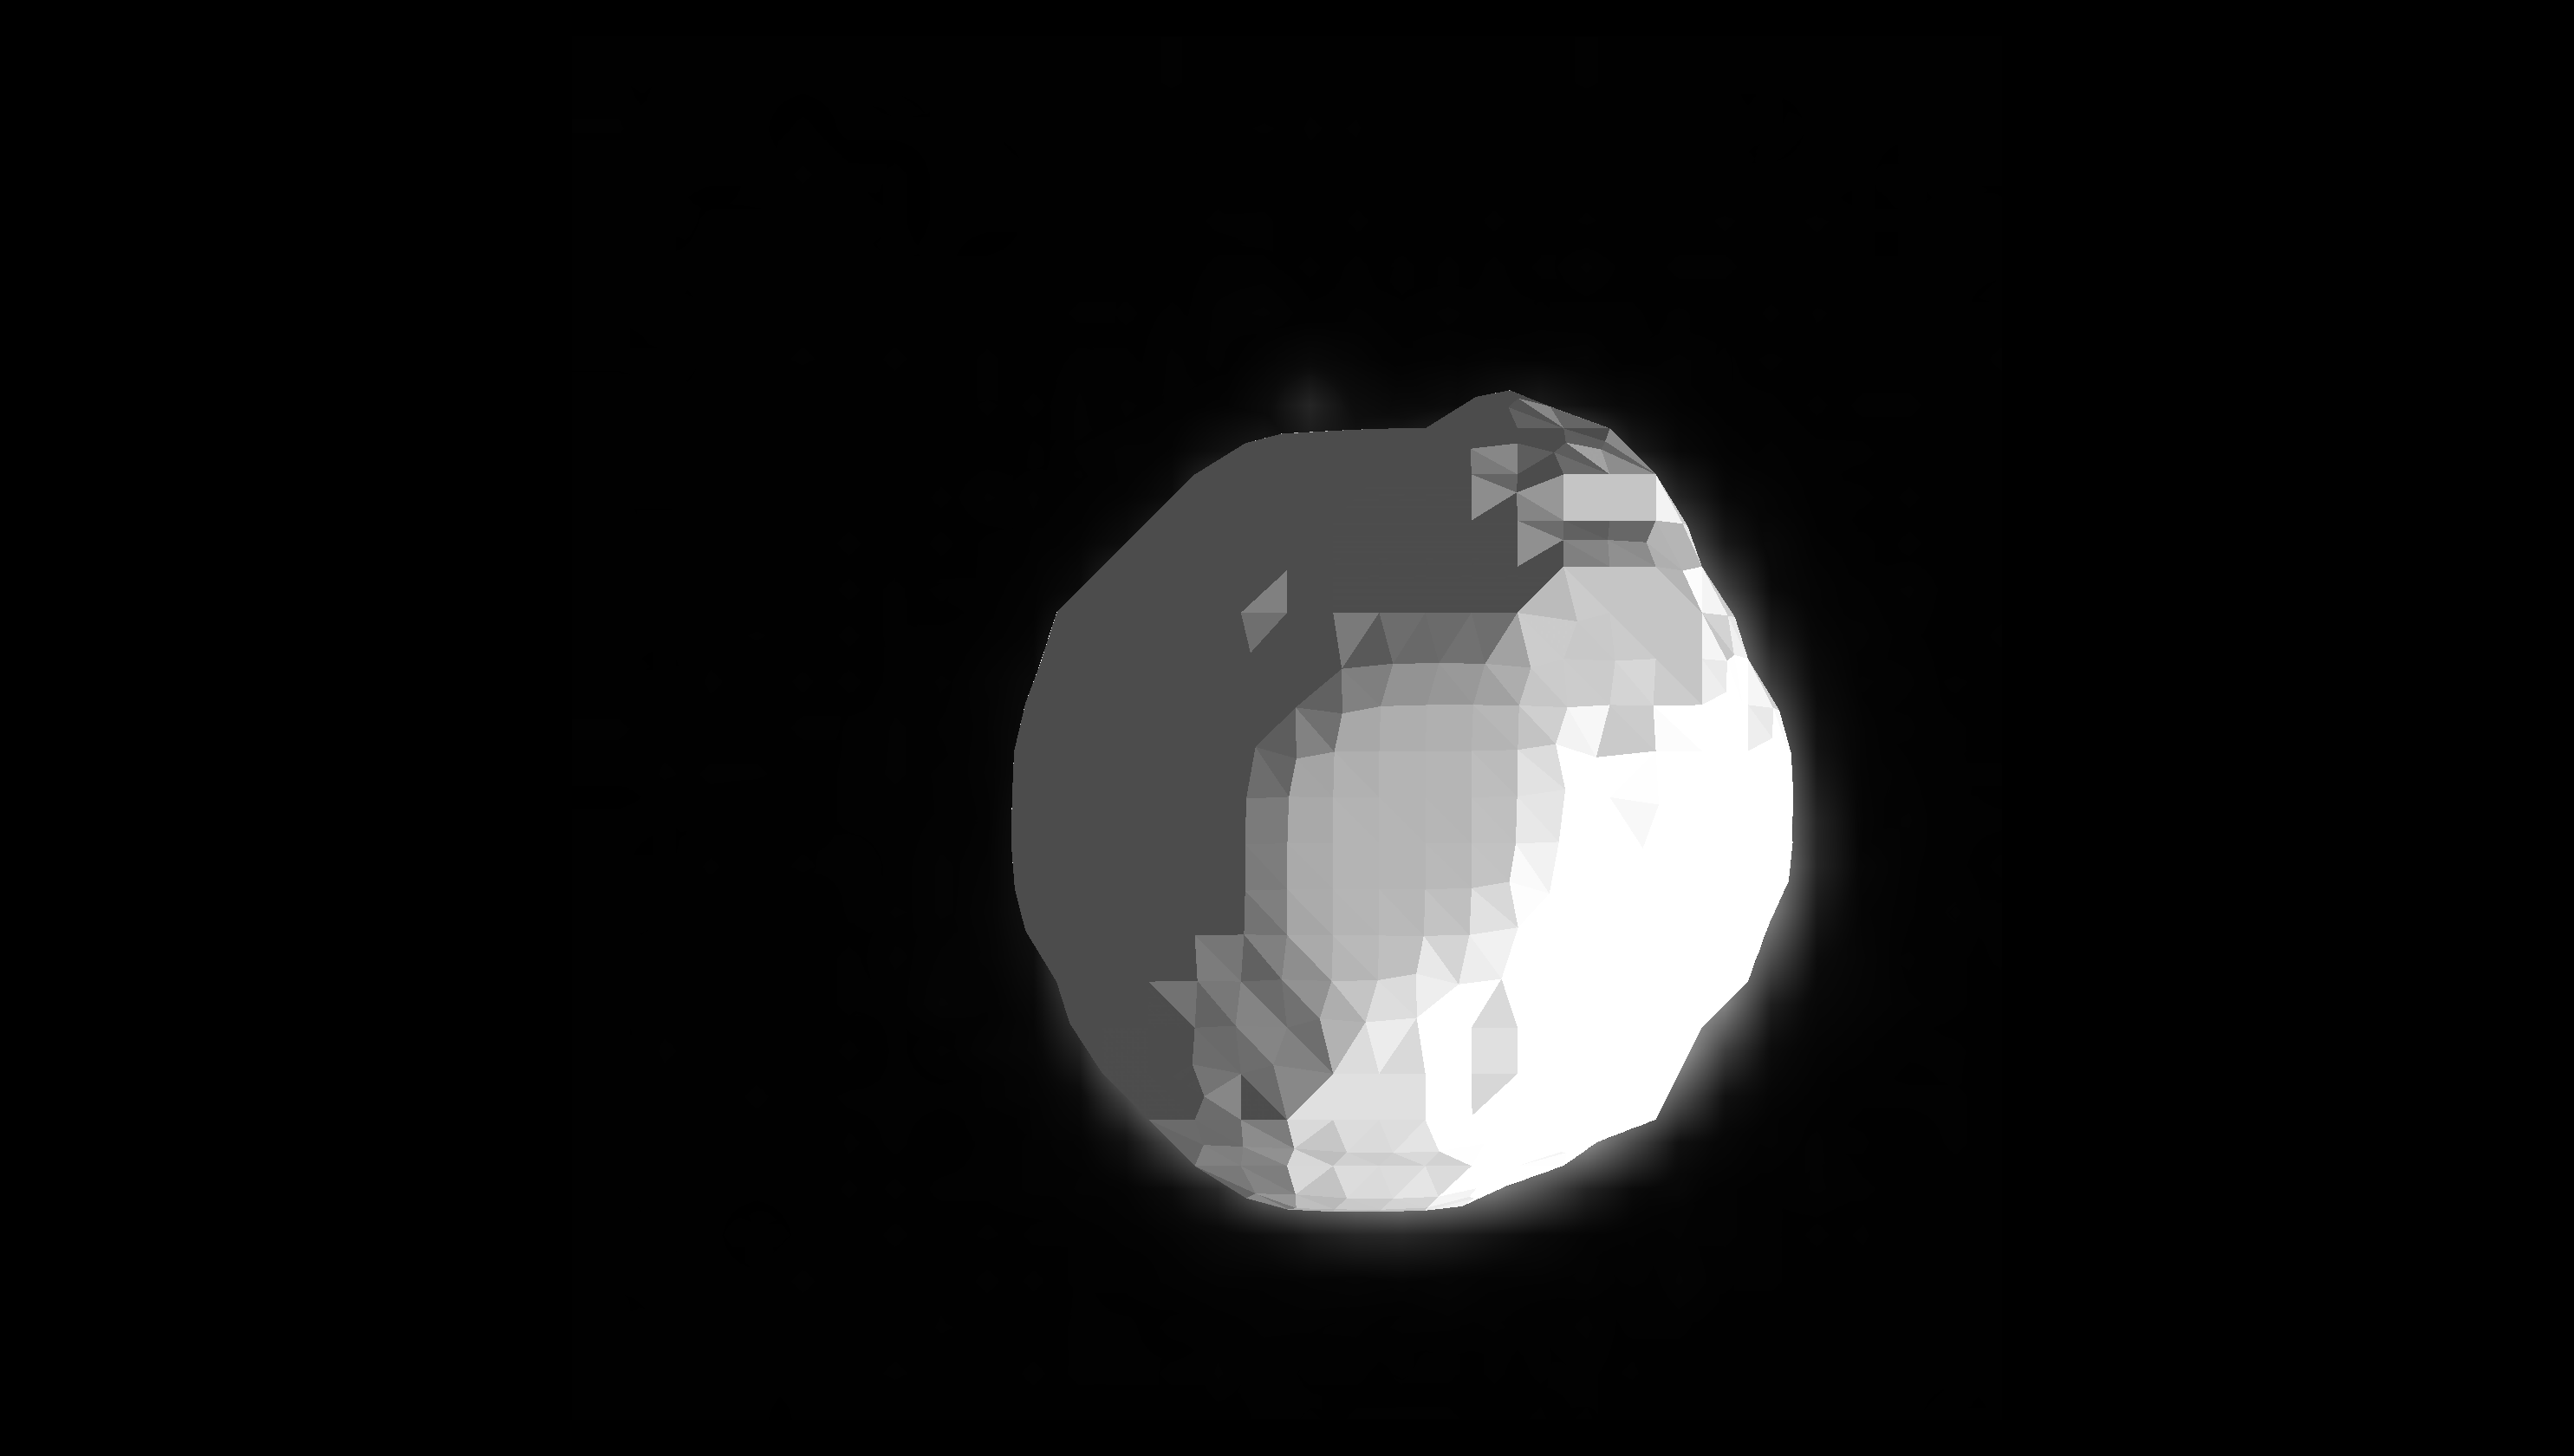

In [11]:
binary_image_layer.visible = False
surface_layer.visible = False
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Surface refinement

In the next step, we will trace-refine the surface, filter the detected points and resample the density of the vertices on the surface to a defined value.

In [12]:
# Trace refinement
results = []
for t in tqdm.tqdm(range(n_frames)):
    vertices = smoothed_surfaces[t].points()
    faces = smoothed_surfaces[t].faces()
    results.append(napari_stress.trace_refinement_of_surface(resampled_image[t], (vertices, faces),
                                                  trace_length=10.0, sampling_distance=0.1,
                                                  scale=binary_image_layer.scale[1:],
                                                  show_progress=False))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:34<00:00,  4.50s/it]


In [27]:
points = [timepoint[0] for timepoint in results]
tracevectors = [timepoint[1] for timepoint in results]

points = napari_stress.list_of_points_to_pointsdata(points)
viewer.add_points(points[0], size=0.2, properties=points[1][)

invalid value encountered in less
invalid value encountered in less


<Points layer 'Points [1]' at 0x14704024880>

In [26]:
points[1]['properties']['profiles'].shape

(23865, 100)

(array([[ 0.        , 15.17495215, 28.25006793, 33.9867834 ],
        [ 0.        , 15.7711259 , 27.82257078, 31.94384737],
        [ 0.        , 15.91147949, 25.99132889, 35.32541217],
        ...,
        [20.        , 50.9100123 , 19.39443512, 25.11207487],
        [20.        , 50.96355908, 18.8452889 , 26.97201935],
        [20.        , 51.1098593 , 19.98177262, 28.83901221]]),
 {'properties': {'fit_errors': array([[0.12447907, 0.00361844, 0.0014039 , 0.00163855],
          [0.10230131, 0.00301513, 0.00096051, 0.00141068],
          [0.08015097, 0.00232738, 0.00081209, 0.00109671],
          ...,
          [0.17277794, 0.00309654, 0.00100766, 0.00176141],
          [0.1697522 , 0.00289291, 0.00108092, 0.00168509],
          [0.1952301 , 0.00381301, 0.00091672, 0.00197986]]),
   'fit_params': array([[ 6.02419523e+01,  7.72909447e-01,  1.11242393e-01,
            3.20803887e-02],
          [ 5.81719641e+01,  7.95198048e-01,  9.99159782e-02,
            1.81941422e-02],
          [ 